## <a id='toc1_1_'></a>[Why search is better than fine-tuning](#toc0_)


**Table of contents**<a id='toc0_'></a>    
- [Why search is better than fine-tuning](#toc1_1_)    
  - [Search](#toc1_2_)    
  - [Full procedure](#toc1_3_)    
    - [Costs](#toc1_3_1_)    
  - [Preamble](#toc1_4_)    
    - [You can give PALM knowledge about a topic by inserting it into an input message](#toc1_4_1_)    
  - [Prepare search data](#toc1_5_)    
  - [Search](#toc1_6_)    
- [SideBard with Search Behind the Scenes](#toc2_)    
- [Example questions](#toc3_)    
    - [More examples](#toc3_1_1_)    
- [Troubleshooting wrong answers](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


PALM or GPT can learn knowledge in two ways:

- Via model weights (i.e., fine-tune the model on a training set)
- Via model inputs (i.e., insert the knowledge into an input message)

Although fine-tuning can feel like the more natural option—training on data is how GPT learned all of its other knowledge, after all—we generally do not recommend it as a way to teach the model knowledge. Fine-tuning is better suited to teaching specialized tasks or styles, and is less reliable for factual recall.

As an analogy, model weights are like long-term memory. When you fine-tune a model, it's like studying for an exam a week away. When the exam arrives, the model may forget details, or misremember facts it never read.

In contrast, message inputs are like short-term memory. When you insert knowledge into a message, it's like taking an exam with open notes. With notes in hand, the model is more likely to arrive at correct answers.

One downside of text search relative to fine-tuning is that each model is limited by a maximum amount of text it can read at once:

| Model           | Maximum text length       |
|-----------------|---------------------------|
| `gpt-3.5-turbo` | 4,096 tokens (~5 pages)   |
| `gpt-4`         | 8,192 tokens (~10 pages)  |
| `gpt-4-32k`     | 32,768 tokens (~40 pages) |

Continuing the analogy, you can think of the model like a student who can only look at a few pages of notes at a time, despite potentially having shelves of textbooks to draw upon.

Therefore, to build a system capable of drawing upon large quantities of text to answer questions, we recommend using a Search-Ask approach.


## <a id='toc1_2_'></a>[Search](#toc0_)

Text can be searched in many ways. E.g.,

- Lexical-based search
- Graph-based search
- Embedding-based search

This example notebook uses embedding-based search. [Embeddings](https://platform.openai.com/docs/guides/embeddings) are simple to implement and work especially well with questions, as questions often don't lexically overlap with their answers.

Consider embeddings-only search as a starting point for your own system. Better search systems might combine multiple search methods, along with features like popularity, recency, user history, redundancy with prior search results, click rate data, etc. Q&A retrieval performance may also be improved with techniques like [HyDE](https://arxiv.org/abs/2212.10496), in which questions are first transformed into hypothetical answers before being embedded. Similarly, GPT can also potentially improve search results by automatically transforming questions into sets of keywords or search terms.

## <a id='toc1_3_'></a>[Full procedure](#toc0_)

Specifically, this notebook demonstrates the following procedure:

1. Prepare search data (once per document)
    1. Collect: We'll download a few hundred Wikipedia articles about the 2022 Olympics
    2. Chunk: Documents are split into short, mostly self-contained sections to be embedded
    3. Embed: Each section is embedded with the OpenAI API
    4. Store: Embeddings are saved (for large datasets, use a vector database)
2. Search (once per query)
    1. Given a user question, generate an embedding for the query from the OpenAI API
    2. Using the embeddings, rank the text sections by relevance to the query
3. Ask (once per query)
    1. Insert the question and the most relevant sections into a message to GPT
    2. Return GPT's answer

### <a id='toc1_3_1_'></a>[Costs](#toc0_)

Because GPT is more expensive than embeddings search, a system with a decent volume of queries will have its costs dominated by step 3.

- For `gpt-3.5-turbo` using ~1,000 tokens per query, it costs ~$0.002 per query, or ~500 queries per dollar (as of Apr 2023)
- For `gpt-4`, again assuming ~1,000 tokens per query, it costs ~$0.03 per query, or ~30 queries per dollar (as of Apr 2023)

Of course, exact costs will depend on the system specifics and usage patterns.

# <a id='toc1_4_'></a>[Preamble](#toc0_)

We'll begin by:
- Importing the necessary libraries
- Selecting models for embeddings search and question answering



In [1]:
# imports
import ast  # for converting embeddings saved as strings back to arrays
import openai  # for calling the OpenAI API
import pandas as pd  # for storing text and embeddings data
import tiktoken  # for counting tokens
from scipy import spatial  # for calculating vector similarities for search
import os
import openai
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, Markdown
import warnings
from api_doc import *

warnings.filterwarnings('ignore')

# models
EMBEDDING_MODEL = "text-embedding-ada-002"
GPT_MODEL = "gpt-3.5-turbo"

# API configuration
openai.api_key = OPEN_AI_KEY

# for LangChain
os.environ["OPENAI_API_KEY"] = OPEN_AI_KEY



C:\Users\Samsickle\AppData\Local\Temp\ipykernel_744\1515246174.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, Markdown


## <a id='toc1_5_'></a>[Prepare search data](#toc0_)

To save you the time & expense, we've prepared a pre-embedded dataset of a few hundred Wikipedia articles about the 2022 Winter Olympics.

To see how we constructed this dataset, or to modify it yourself, see [Embedding Wikipedia articles for search](Embedding_Wikipedia_articles_for_search.ipynb).

In [2]:
# get the answer from the response
df = pd.read_csv('google_docs.csv')

# convert embeddings from CSV str type back to list type
df['embedding'] = df['embedding'].apply(ast.literal_eval)


df.shape

(531, 2)

## <a id='toc1_6_'></a>[Search](#toc0_)

Now we'll define a search function that:
- Takes a user query and a dataframe with text & embedding columns
- Embeds the user query with the OpenAI API or Palm2
- Uses distance between query embedding and text embeddings to rank the texts
- Returns two lists:
    - The top N texts, ranked by relevance
    - Their corresponding relevance scores

In [3]:
# search function
def strings_ranked_by_relatedness(
    query: str,
    df: pd.DataFrame,
    relatedness_fn=lambda x, y: 1 - spatial.distance.cosine(x, y),
    top_n: int = 100
) -> tuple[list[str], list[float]]:
    """Returns a list of strings and relatednesses, sorted from most related to least."""
    query_embedding_response = openai.Embedding.create(
        model=EMBEDDING_MODEL,
        input=query,
    )
    query_embedding = query_embedding_response["data"][0]["embedding"]
    strings_and_relatednesses = [
        (row["text"], relatedness_fn(query_embedding, row["embedding"]))
        for i, row in df.iterrows()
    ]
    strings_and_relatednesses.sort(key=lambda x: x[1], reverse=True)
    strings, relatednesses = zip(*strings_and_relatednesses)
    return strings[:top_n], relatednesses[:top_n]




# <a id='toc2_'></a>[SideBard with Search Behind the Scenes](#toc0_)

With the search function above, we can now automatically retrieve relevant knowledge and insert it into messages to GPT.

Below, we define a function `ask` that:
- Takes a user query
- Searches for text relevant to the query
- Stuffs that text into a message for GPT
- Sends the message to GPT
- Returns GPT's answer

In [4]:
# intergrating the Information of the user into the question

age = {
    "0-9": "I'm 0 to 9 years old.",
    "10-19": "I'm 10 to 19 years old.",
    "20-29": "I'm 20 to 29 years old.",
    "30-39": "I'm 30 to 39 years old.",
    "40-49": "I'm 40 to 49 years old.",
    "50-59": "I'm 50 to 59 years old.",
    "60-69": "I'm 60 to 69 years old.",
    "70 and above": "I'm 70 years old or above."
}

ai_familiarity = {
    "beginner": "I have basic knowledge about AI.",
    "moderate": "I have some experience and understanding about AI.",
    "expert": "I am highly knowledgeable and experienced about AI."
}

# Demo Personas
name = 'Samir'
input_age = "40-49"
input_ai_familiarity = "beginner"
custom_intro = f'{age[input_age]} {ai_familiarity[input_ai_familiarity]} Use the below articles on Google\'s help and user experience documentation to answer the subsequent question. If the answer cannot be found in the articles, answer to the best of your abilities but convey that you were unable to find the information with the Google Help dataset you were provided. Please say hello to {name} before offering your answer"'


# Model Parameters for Safety and Reliability
max_response_tokens = 300
temperature = 0.3
diversity_penlty = 0.5
Echo = True




In [5]:
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))


def query_message(
    query: str,
    df: pd.DataFrame,
    model: str,
    token_budget: int
) -> str:
    """Return a message for GPT, with relevant source texts pulled from a dataframe."""
    strings, relatednesses = strings_ranked_by_relatedness(query, df)
    introduction = f'{custom_intro}'
    question = f"\n\nQuestion: {query}"
    message = introduction
    for string in strings:
        next_article = f'\n\Google Help article section:\n"""\n{string}\n"""'
        if (
            num_tokens(message + next_article + question, model=model)
            > token_budget
        ):
            break
        else:
            message += next_article
    return message + question

def ask(
    query: str,
    df: pd.DataFrame = df,
    model: str = GPT_MODEL,
    token_budget: int = 4096 - 500,
    print_message: bool = False,
    max_response_tokens: int = max_response_tokens,
    temperature: float = temperature,
    diversity_penalty: float = diversity_penlty,
    top_p_value: float = 0.9
) -> str:
    """Answers a query using GPT and a dataframe of relevant texts and embeddings."""
    message = query_message(query, df, model=model, token_budget=token_budget)
    if print_message:
        print(message)
    messages = [
        {"role": "system", "content": "You answer questions about the Google AI Powered Products."},
        {"role": "user", "content": message},
    ]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0,
        max_tokens=max_response_tokens,
        top_p=top_p_value
    )
    response_message = response["choices"][0]["message"]["content"]
    return response_message


# <a id='toc3_'></a>[Example questions](#toc0_)

Finally, let's ask our system our original question about gold medal curlers:

### <a id='toc3_1_1_'></a>[More examples](#toc0_)

Below are a few more examples of the system in action. Feel free to try your own questions, and see how it does. In general, search-based systems do best on questions that have a simple lookup, and worst on questions that require multiple partial sources to be combined and reasoned about.

In [6]:
def display_answer_in_markdown(question: str, category: str):
    """Displays the answer in a user-friendly format using Markdown."""
    answer = ask(question)
    markdown_output = f"""
### Category: {category}  
### Question:  
{question}
    ---
### Answer:  
{answer} 
    ---
    """
    display(Markdown(markdown_output))


In [7]:
# Objective harder question
display_answer_in_markdown('How to sum all the costs of this store in sheets?', 'Objective Harder Question')



### Category: Objective Harder Question  
### Question:  
How to sum all the costs of this store in sheets?
    ---
### Answer:  
Hello Samir! To sum all the costs of a store in Google Sheets, you can use the SUM function. Here's how you can do it:

1. Select the cell where you want the sum to appear.
2. Type "=SUM(" in the cell.
3. Select the range of cells that contain the costs you want to sum.
4. Close the parentheses ")" and press Enter.

For example, if the costs are in cells A1 to A10, you would enter "=SUM(A1:A10)" in the cell.

This will calculate the sum of all the costs in the specified range and display the result in the selected cell. 
    ---
    

In [8]:
# # Wrong Question or Confusing Question
# display_answer_in_markdown('How to dadawdja?', 'Wrong or Confusing Question')


In [9]:
# # Question about Bard
# display_answer_in_markdown('How do I delete my Bard history?', 'Question about Bard')


In [10]:
# # Question about Bard's integrity and character
# display_answer_in_markdown('Should I trust Bard?', "Bard's Integrity and Character", )


In [11]:
# # Fun Question
# display_answer_in_markdown('What should the name for our team be, we are developing a google product that will enhance a user\'s understanding of the AI powered product they are using?', 'Fun Question')


# <a id='toc4_'></a>[Troubleshooting wrong answers](#toc0_)

To see whether a mistake is from a lack of relevant source text (i.e., failure of the search step) or a lack of reasoning reliability (i.e., failure of the ask step), you can look at the text GPT was given by setting `print_message=True`.

In this particular case, looking at the text below, it looks like the #1 article given to the model did contain medalists for all three events, but the later results emphasized the Men's and Women's tournaments, which may have distracted the model from giving a more complete answer.

In [12]:
# set print_message=True to see the source text GPT was working off of
ask('What is Bard bad at?', print_message=True)

I'm 40 to 49 years old. I have basic knowledge about AI. Use the below articles on Google's help and user experience documentation to answer the subsequent question. If the answer cannot be found in the articles, answer to the best of your abilities but convey that you were unable to find the information with the Google Help dataset you were provided. Please say hello to Samir before offering your answer"
\Google Help article section:
"""
Title: Google Bard , Description: Skip to main content
Bard
Use Bard
You can use Bard to help move your ideas forward. With a little help from Bard, you can do things like:

Brainstorm ideas, develop a plan, or find different ways to get things done
Get a quick, easy to understand summary of more complex topics
Create first drafts of outlines, emails, blog posts, poems, and much more
What you need
A personal Google Account that you manage on your own, or a Google Workspace account for which your administrator has enabled access to Bard. You still can’

"Hello Samir! According to the provided Google Help articles, Bard may give inaccurate or inappropriate information. It is mentioned that Bard's responses may not always be accurate or suitable. Users are encouraged to provide feedback to help improve Bard's accuracy and safety."

In [13]:

# Set up the data
# strings, relatednesses = strings_ranked_by_relatedness("How do i sum a function?", df, top_n=50)
answers = pd.DataFrame(strings_ranked_by_relatedness("How do i sum a function?", df, top_n=50))

answers = answers.T.rename(columns={0: 'Answer', 1: 'Relatedness'}).sort_values("Relatedness", ascending=False).reset_index(drop=True)

answers.head()

,Answer,Relatedness
0,"Type: Math, Name: SUM, Syntax: SUM(value1, [va...",0.839207
1,"Type: Math, Name: SUBTOTAL, Syntax: SUBTOTAL(f...",0.817892
2,"Type: Math, Name: SUMIF, Syntax: SUMIF(range, ...",0.813362
3,"Type: Engineering, Name: IMSUM, Syntax: IMSUM(...",0.809927
4,"Type: Math, Name: SUMIFS, Syntax: SUMIFS(sum_r...",0.808521


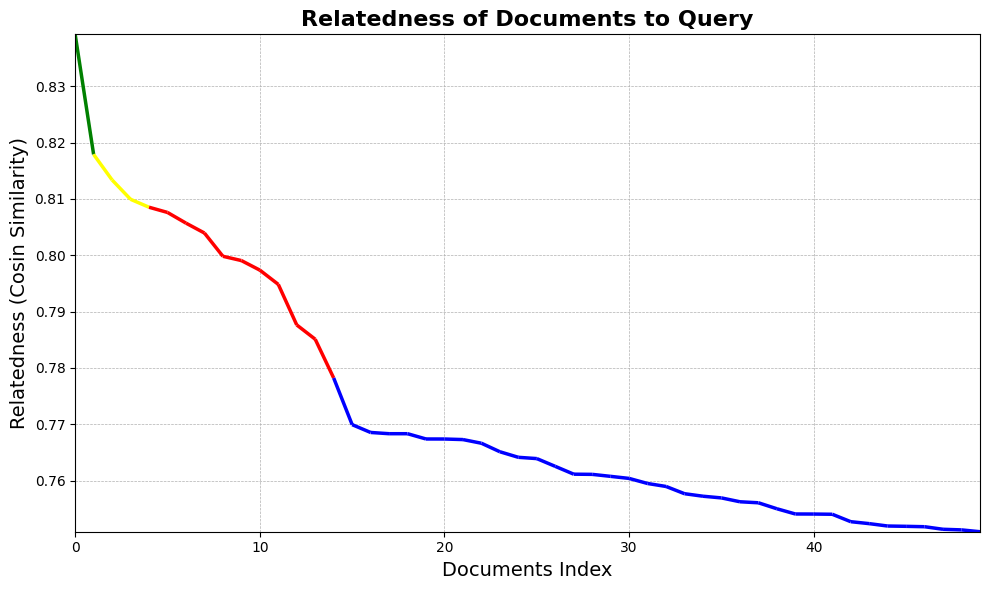

In [14]:
# Create the plot
plt.figure(figsize=(10, 6))

# Define a set of colors and create a custom colormap
colors = ['blue', 'red', 'yellow', 'green']
num_colors = len(colors)
bins = np.linspace(answers.Relatedness.min(), answers.Relatedness.max(), num_colors)
segment_colors = np.array([colors[np.digitize(val, bins=bins)-1] for val in answers.Relatedness])

# Create line segments and color them
points = np.array([answers.index, answers.Relatedness]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, colors=segment_colors, linewidth=2.5)
plt.gca().add_collection(lc)

# Beautify the plot
plt.title("Relatedness of Documents to Query", fontsize=16, fontweight='bold')
plt.xlabel("Documents Index", fontsize=14)
plt.ylabel("Relatedness (Cosin Similarity)", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(answers.index.min(), answers.index.max())
plt.ylim(answers.Relatedness.min(), answers.Relatedness.max())
plt.tight_layout()

# Display the plot
plt.show()


In [15]:

# Set up the data
# strings, relatednesses = strings_ranked_by_relatedness("How do i sum a function?", df, top_n=50)
answers = pd.DataFrame(strings_ranked_by_relatedness("How do i sum a function?", df, top_n=15))

answers = answers.T.rename(columns={0: 'Answer', 1: 'Relatedness'}).sort_values("Relatedness", ascending=False).reset_index(drop=True)

answers.head()

,Answer,Relatedness
0,"Type: Math, Name: SUM, Syntax: SUM(value1, [va...",0.83915
1,"Type: Math, Name: SUBTOTAL, Syntax: SUBTOTAL(f...",0.817854
2,"Type: Math, Name: SUMIF, Syntax: SUMIF(range, ...",0.813312
3,"Type: Engineering, Name: IMSUM, Syntax: IMSUM(...",0.80991
4,"Type: Math, Name: SUMIFS, Syntax: SUMIFS(sum_r...",0.808488


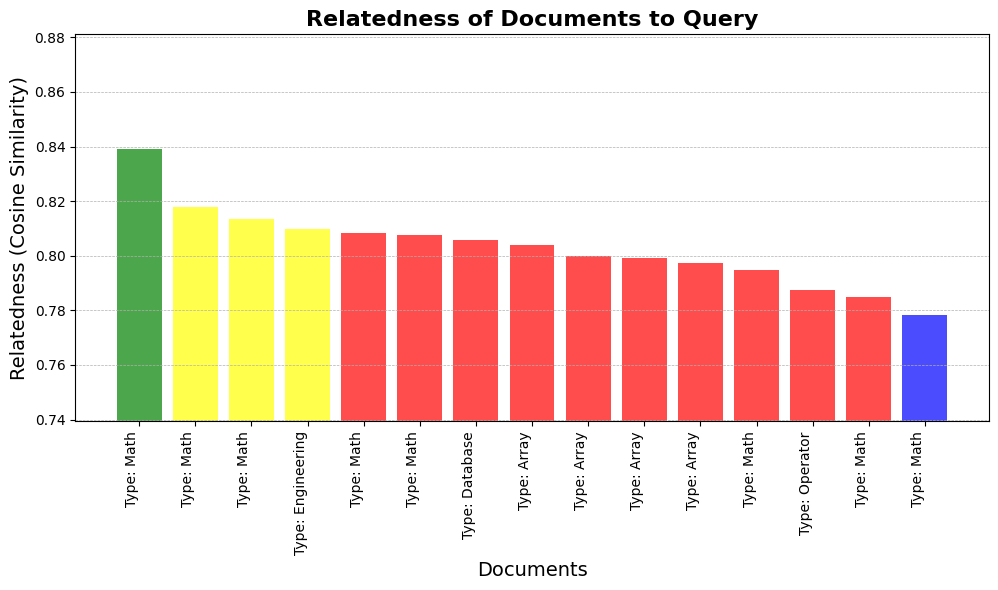

In [16]:


plt.figure(figsize=(10, 6))

# Create the bar plot
plt.bar(answers.index, answers.Relatedness, color=segment_colors, alpha=0.7)

# Beautify the plot
plt.title("Relatedness of Documents to Query", fontsize=16, fontweight='bold')
plt.xlabel("Documents", fontsize=14)
plt.ylabel("Relatedness (Cosine Similarity)", fontsize=14)
plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)
plt.xticks(ticks=answers.index, labels=answers['Answer'].str.split(',').str[0], rotation=90, ha='right')  # Set x-axis labels as the answers
plt.tight_layout()
plt.ylim(answers.Relatedness.min()*.95, answers.Relatedness.max()*1.05)

# Display the plot
plt.show()


# Please Play with SideBard Chatbot!

1. Ask any question that is in the google's help documents for google sheets, google docs, or Bard and get the answer! 

2. SideBard will say "I don't know" if it doesn't know the answer from the documents we have compiled, but may give a reasonable guess based on what it searched. 

3. Why did SideBard answer the way it did? Add `print_message=True` to the `ask` function to see the text it searched.

4. Curious for more? Look at the top 10 results from the search by adding `print_search=True` to the `ask` function.

In [17]:
your_question = input("What is your question? ")

display_answer_in_markdown(your_question, 'User Question')


In [19]:
ask(your_question, print_message=True)

I'm 40 to 49 years old. I have basic knowledge about AI. Use the below articles on Google's help and user experience documentation to answer the subsequent question. If the answer cannot be found in the articles, answer to the best of your abilities but convey that you were unable to find the information with the Google Help dataset you were provided. Please say hello to Samir before offering your answer"
\Google Help article section:
"""
Title: Googe Docs, Description: Skip to main content
Help Center
Community
Google Docs Editors
Google DocsInsert or delete images and videos
Insert or delete images and videos
You can add or remove photos, videos or .gif files in Google Docs or Sheets. In Google Slides you can add photos, videos or audio. To help plan your presentation, you can also add image placeholders.

Computer AndroidiPhone & iPad
Add an image to a document or presentation
On your computer, open a document or presentation in Google Docs or Slides.
Click Insert and then Image.
Ch

'Hello Samir! Based on the provided articles, here are the answers to your question:\n\n1. How can I add an image to a Google Docs document or presentation?\n- To add an image to a Google Docs document or presentation, you can follow these steps:\n  - Open the document or presentation in Google Docs or Slides.\n  - Click on "Insert" and then "Image".\n  - Choose where to get your image from, such as uploading from your computer, searching the web, using an image from Google Drive, or inserting a link to the image.\n  - Click "Insert" or "Open" to add the image.\n\n2. How can I add a video to a Google Slides presentation?\n- To add a video to a Google Slides presentation, you can follow these steps:\n  - Open the presentation in Google Slides.\n  - Click on the slide where you want to add the video.\n  - Click on "Insert" and then "Video".\n  - Select where to get your video from, such as searching YouTube, using a URL, or selecting from Google Drive.\n  - Choose the video and click "Se

In [20]:
# Set up the data
answers = pd.DataFrame(strings_ranked_by_relatedness(your_question, df, top_n=15))
answers = answers.T.rename(columns={0: 'Answer', 1: 'Relatedness'}).sort_values("Relatedness", ascending=False).reset_index(drop=True)
answers.head()


,Answer,Relatedness
0,"Title: Googe Docs, Description: Skip to main c...",0.682199
1,"Title: Google Bard , Description: Skip to main...",0.675913
2,"Title: Googe Docs, Description: Skip to main c...",0.674716
3,"Title: Googe Docs, Description: Skip to main c...",0.673527
4,"Title: Googe Docs, Description: Skip to main c...",0.673506


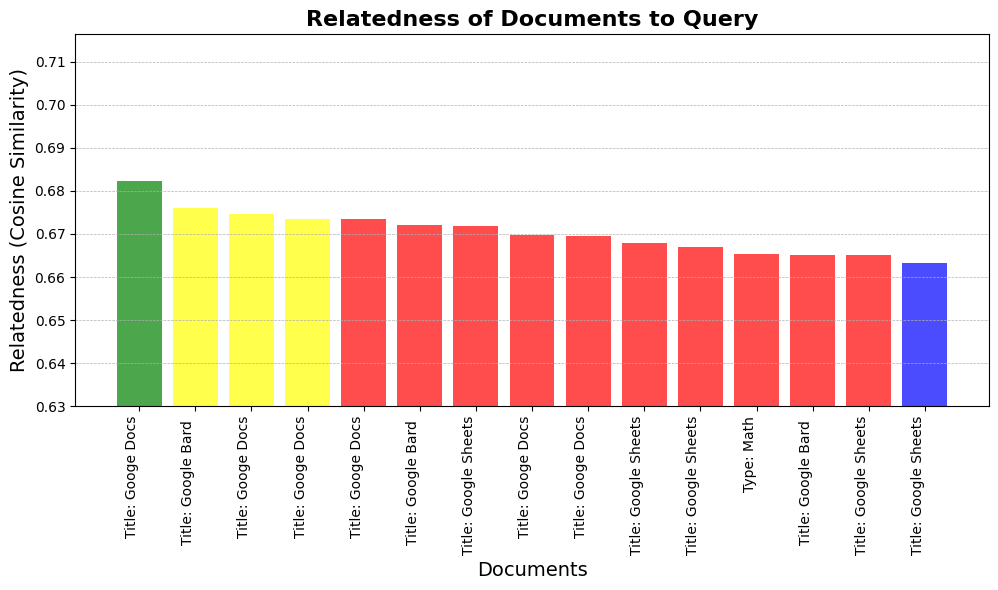

In [21]:

plt.figure(figsize=(10, 6))

# Create the bar plot
plt.bar(answers.index, answers.Relatedness, color=segment_colors, alpha=0.7)

# Beautify the plot
plt.title("Relatedness of Documents to Query", fontsize=16, fontweight='bold')
plt.xlabel("Documents", fontsize=14)
plt.ylabel("Relatedness (Cosine Similarity)", fontsize=14)
plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)
plt.xticks(ticks=answers.index, labels=answers['Answer'].str.split(',').str[0], rotation=90, ha='right')  # Set x-axis labels as the answers
plt.tight_layout()
plt.ylim(answers.Relatedness.min()*.95, answers.Relatedness.max()*1.05)

# Display the plot
plt.show()
